In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [2]:
data_path = "../data/"
X_train = pd.read_csv(os.path.join(data_path, "X_train_selected.csv"))
X_test  = pd.read_csv(os.path.join(data_path, "X_test_selected.csv"))
y_train = pd.read_csv(os.path.join(data_path, "y_train.csv"))
y_test  = pd.read_csv(os.path.join(data_path, "y_test.csv"))

# 1. Apply K-Means Clustering (elbow method to determine K)
**Steps:**

* Choose number of clusters (k).
* Fit K-Means on the dataset.
* Assign cluster labels to each sample.
* Compare clusters with actual target labels (if available).

In [3]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [4]:
X = full_df.drop(columns=['num'])
y = full_df['num']

In [5]:
X.head()

,0,1,3,4,5,6,7,9,10,11
0,1.581413,-0.118115,0.329584,-0.892316,-1.409958,0.012405,-0.041447,-0.027919,-0.008338,-0.011015
1,0.275094,1.137663,-0.258152,0.652191,-0.171674,-0.283191,-0.779139,-0.049715,0.299429,-0.167772
2,-0.956060,0.484582,-0.628427,1.362815,-0.183272,-0.408920,-0.975655,-0.062027,-0.040025,0.162911
3,-0.068936,0.307044,0.272243,0.974685,-0.071530,-0.440385,0.452494,-0.955516,0.241139,0.186576
4,1.926561,0.673543,0.140135,0.227936,-0.331336,0.489502,-0.155414,0.302765,-0.084141,-0.333127


In [6]:
wcss = []           # Within-cluster sum of squares
dbi_scores = []     # Davies-Bouldin Index
sil_scores = []     # Silhouette Score

k_values = range(2, 11)
for i in k_values:  # Testing K from 2 to 10
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X)
    # Within-cluster sum of squares
    wcss.append(kmeans.inertia_) 
    # Davies-Bouldin Index 
    dbi = davies_bouldin_score(X, kmeans.labels_)
    dbi_scores.append(dbi)
    # Silhouette Score
    sil = silhouette_score(X, kmeans.labels_)
    sil_scores.append(sil)

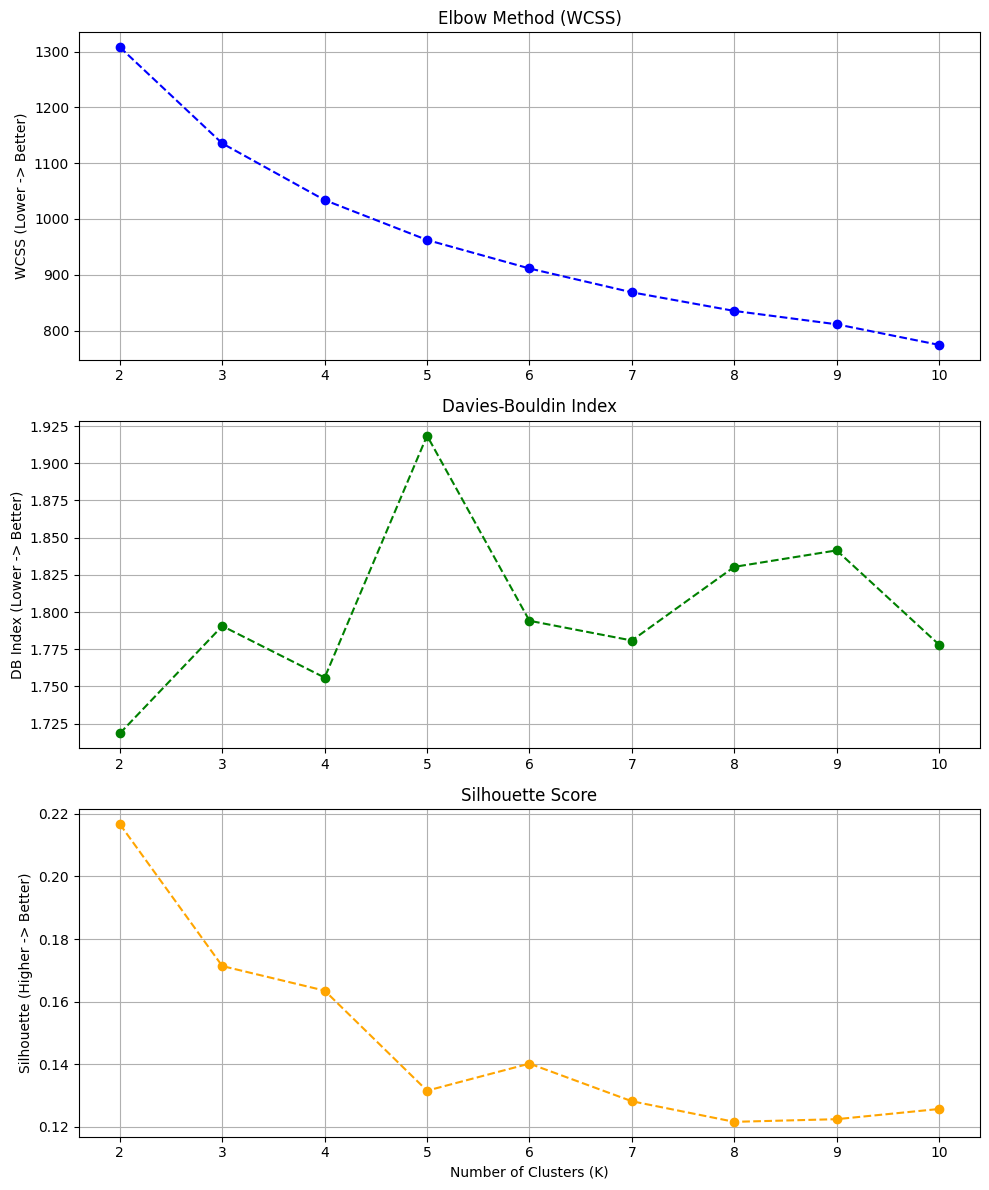

In [7]:
plt.figure(figsize=(10, 12))

# --- Elbow Method ---
plt.subplot(3, 1, 1)
plt.plot(k_values, wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method (WCSS)')
plt.ylabel('WCSS (Lower -> Better)')
plt.grid(True)

# --- Davies-Bouldin Index ---
plt.subplot(3, 1, 2)
plt.plot(k_values, dbi_scores, marker='o', linestyle='--', color='green')
plt.title('Davies-Bouldin Index')
plt.ylabel('DB Index (Lower -> Better)')
plt.grid(True)

# --- Silhouette Score ---
plt.subplot(3, 1, 3)
plt.plot(k_values, sil_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette (Higher -> Better)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
optimal_wcss_k = k_values[np.argmin(wcss)]
print(f"Optimal number of clusters (K) based on WCSS: {optimal_wcss_k}")

optimal_dbi_k = k_values[np.argmin(dbi_scores)]
print(f"Optimal number of clusters (K) based on Davies-Bouldin Index: {optimal_dbi_k}")

optimal_sil_k = k_values[np.argmax(sil_scores)]
print(f"Optimal number of clusters (K) based on Silhouette Score: {optimal_sil_k}")

keys = [optimal_wcss_k, optimal_dbi_k, optimal_sil_k]
optimal_k = max(set(keys), key=keys.count)
print(f"\nOptimal number of clusters (K) based on all metrics: {optimal_k}")

Optimal number of clusters (K) based on WCSS: 10
Optimal number of clusters (K) based on Davies-Bouldin Index: 2
Optimal number of clusters (K) based on Silhouette Score: 2

Optimal number of clusters (K) based on all metrics: 2


In [9]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X)

# compare cluster labels with true labels
comparison_df = pd.DataFrame({'True Labels': y, 'Cluster Labels': kmeans.labels_})
print("Comparison of True Labels and Cluster Labels:")
print(comparison_df.head(20))

Comparison of True Labels and Cluster Labels:
    True Labels  Cluster Labels
0             0               0
1             0               0
2             0               1
3             1               1
4             0               0
5             1               0
6             1               1
7             0               0
8             1               1
9             1               1
10            1               0
11            1               1
12            1               1
13            0               0
14            1               1
15            1               1
16            0               0
17            0               0
18            0               0
19            0               0


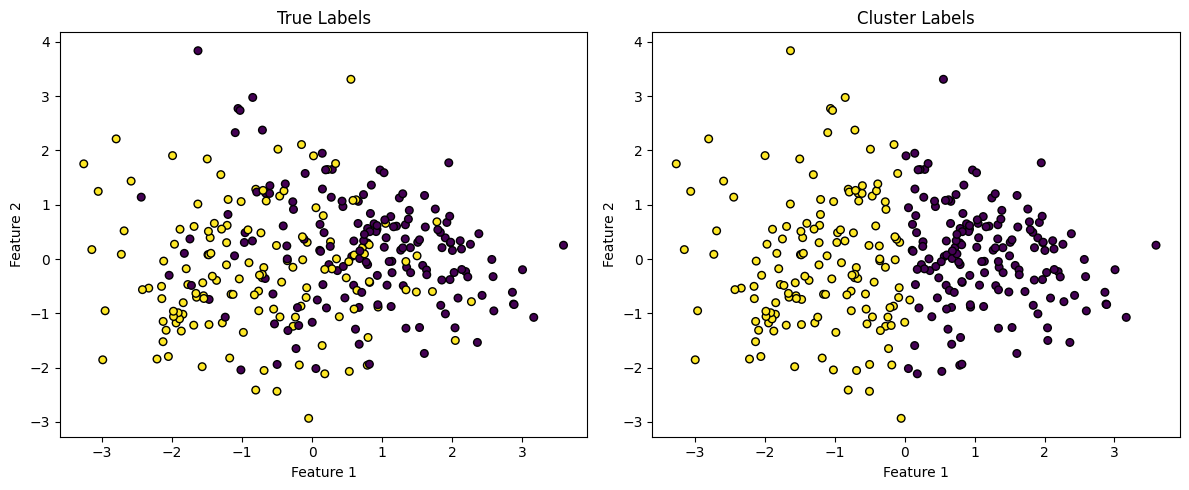

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X['0'], X['1'], c=y, cmap='viridis', s=30, edgecolors='k')
plt.title('True Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X['0'], X['1'], c=kmeans.labels_, cmap='viridis', s=30, edgecolors='k')
plt.title('Cluster Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

**Results:**

* Data was grouped into k clusters.
* Clear cluster assignments obtained for all samples.
* Some overlap between clusters and actual classes (not perfect).

---

# 2. Perform Hierarchical Clustering (dendrogram analysis).
**Steps:**
* Generate dendrogram to visualize cluster merging.
* Select optimal number of clusters from the dendrogram.

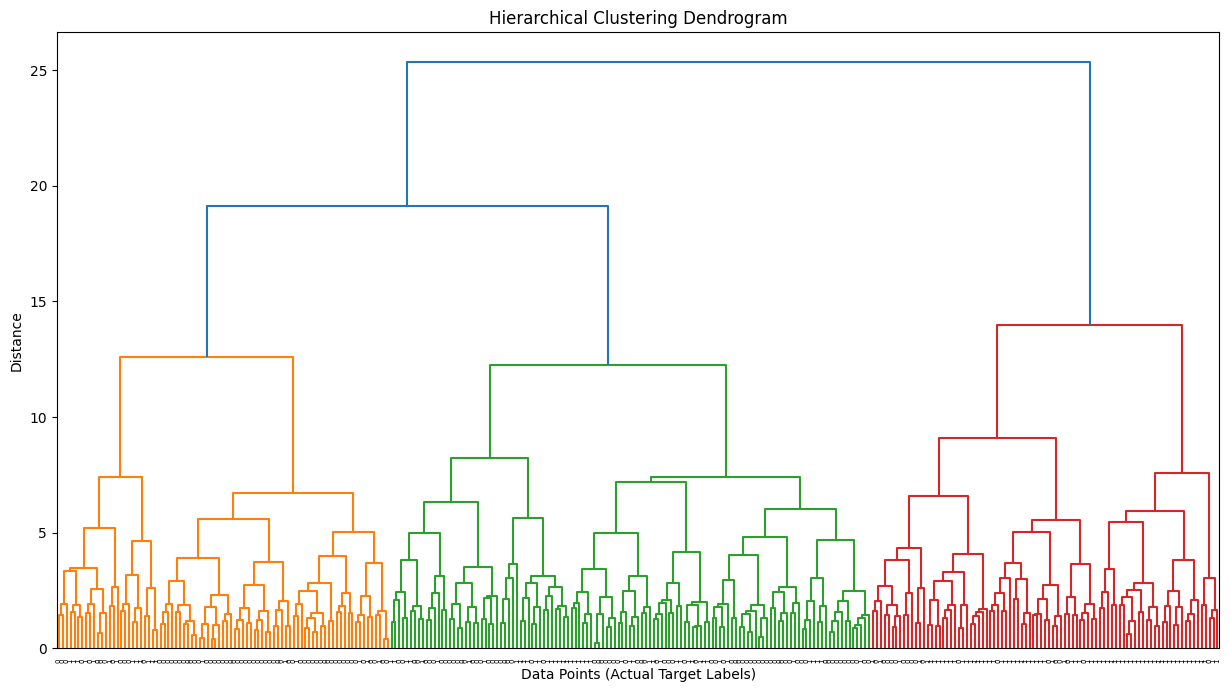

In [11]:
linked = linkage(X, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           labels=y.values,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points (Actual Target Labels)')
plt.ylabel('Distance')
plt.show()

In [12]:
hierarchical_n_clusters = 3
hierarchical_labels = fcluster(linked, hierarchical_n_clusters, criterion='maxclust')

X_clustered_hierarchical = pd.DataFrame({'True Labels': y, 'Cluster Labels': hierarchical_labels})

print(f"\nFirst 5 rows of data with Hierarchical Clusters (K={hierarchical_n_clusters}):")
print(X_clustered_hierarchical.head())


First 5 rows of data with Hierarchical Clusters (K=3):
   True Labels  Cluster Labels
0            0               3
1            0               2
2            0               2
3            1               2
4            0               3


**Results:**
* Hierarchical clustering successfully grouped samples.
* Dendrogram provided a clear view of cluster hierarchy.
* Final clusters consistent with K-Means results in some areas.

---

# 3. Compare clusters with actual disease labels.
**Steps:**
* Compare K-Means and Hierarchical labels with actual target labels

K-Means vs Actual: Adjusted Rand Score = 0.2228
K-Means vs Actual: Normalized Mutual Information Score = 0.1682
Hierarchical vs Actual: Adjusted Rand Score = 0.1246
Hierarchical vs Actual: Normalized Mutual Information Score = 0.1260


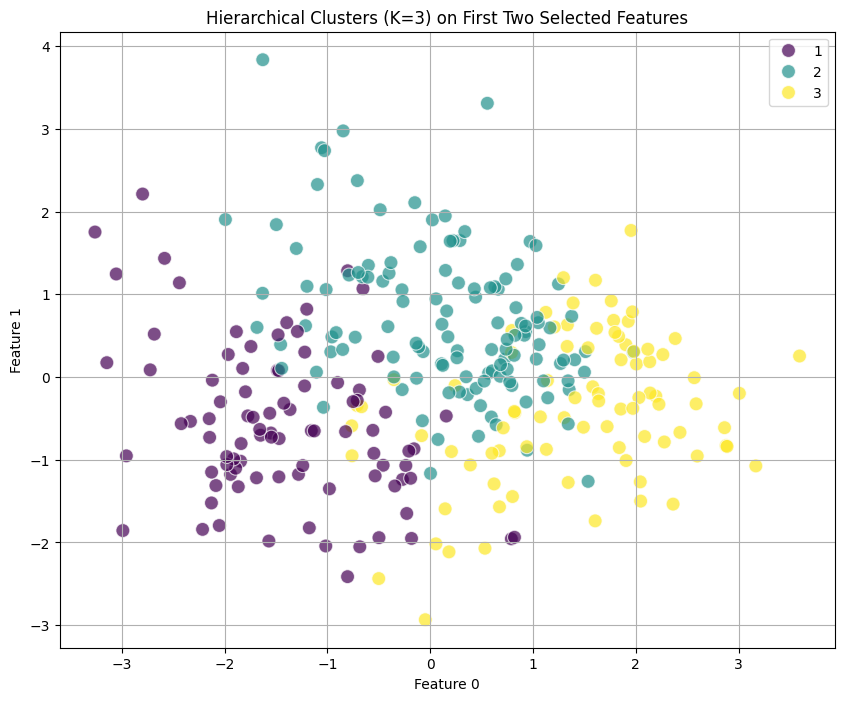

In [13]:
# 1. Compare K-Means labels with actual target labels
kmeans_adj_rand_score = adjusted_rand_score(y, kmeans.labels_)
kmeans_nmi_score = normalized_mutual_info_score(y, kmeans.labels_)

print(f"K-Means vs Actual: Adjusted Rand Score = {kmeans_adj_rand_score:.4f}")
print(f"K-Means vs Actual: Normalized Mutual Information Score = {kmeans_nmi_score:.4f}")

# 2. Compare Hierarchical labels with actual target labels
hierarchical_adj_rand_score = adjusted_rand_score(y, hierarchical_labels)
hierarchical_nmi_score = normalized_mutual_info_score(y, hierarchical_labels)

print(f"Hierarchical vs Actual: Adjusted Rand Score = {hierarchical_adj_rand_score:.4f}")
print(f"Hierarchical vs Actual: Normalized Mutual Information Score = {hierarchical_nmi_score:.4f}")

if X.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X['0'], y=X['1'],
                    hue=hierarchical_labels,
                    data=X_clustered_hierarchical,
                    palette='viridis', s=100, alpha=0.7)
    plt.title(f'Hierarchical Clusters (K={hierarchical_n_clusters}) on First Two Selected Features')
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.grid(True)
    plt.show()
